This model is more strict with what it defines as a fluent or disfluent moment. i.e. more labellers must have marked it as dsyfluent for it to be labbeled so.

difficult to understand field doesn't seem helpful
does interjections count ... yes for now 

In [1]:
import pandas as pd
from pathlib import Path

def read_data(csv_path):
    """Read the CSV file into a DataFrame."""
    return pd.read_csv(csv_path)

def compute_fluency_label(df, columns):
    """Compute the fluency label based on the average of specified columns."""
    fluency_label = (df[columns].mean(axis=1) < 0.3).astype(int)
    df['Fluency Label'] = fluency_label
    return df

def remove_unwanted_rows(df, column, value):
    """Remove rows where the column matches the specified value."""
    return df[df[column] != value]

def generate_clip_paths(df, base_path):
    """Generate file paths for audio clips based on DataFrame entries."""
    def path_for_row(row):
        folder = Path(base_path) / row['Show'] / str(int(row['EpId']))
        filename = f"{row['Show']}_{int(row['EpId'])}_{int(row['ClipId'])}.wav"
        return str(folder / filename)
    
    df['ClipPath'] = df.apply(path_for_row, axis=1)
    return df

# Main script
csv_file_path = Path(r"C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\SEP-28k_labels.csv")
base_path = Path(r"C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\[CLIP_DIR]")

df = read_data(csv_file_path)
cols_to_avg = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
df = compute_fluency_label(df, cols_to_avg)
df = remove_unwanted_rows(df, 'Show', 'StrongVoices')
df = generate_clip_paths(df, base_path)

simple_df = df[['ClipPath', 'Fluency Label']]
print(simple_df.describe())

       Fluency Label
count   25869.000000
mean        0.386370
std         0.486926
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


# Preprocessing Audio Data

Audio Normalization: Ensure all audio clips are at a consistent volume level.
Sampling Rate Consistency: Convert all audio files to the same sampling rate if they differ.
Audio Length: Consider making all audio clips the same length either by trimming or padding shorter clips.
Feature Extraction: Convert audio signals into a form that machine learning algorithms can work with. Common features include Mel-frequency cepstral coefficients (MFCCs), spectrograms, or even raw waveforms for deep learning models.

## Audio Normalization

In [30]:
import librosa

# Function to calculate RMS of an audio clip
def calculate_rms(audio_path):
    y, _ = librosa.load(audio_path)
    rms = librosa.feature.rms(y=y).mean()
    return rms

# Calculate RMS for each clip and append it to the DataFrame
df['RMS'] = df['ClipPath'].apply(calculate_rms)

# Display the updated DataFrame
print(df.head())


         Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  32025120       0                 0   
2  HeStutters     0       2  34809760  34857760       0                 0   
3  HeStutters     0       3  35200640  35248640       0                 0   
4  HeStutters     0       4  35721920  35769920       0                 0   

   Prolongation  Block  SoundRep  WordRep  DifficultToUnderstand  \
0             0      0         0        0                      0   
1             0      0         0        0                      0   
2             0      0         0        0                      0   
3             1      0         0        0                      0   
4             0      0         0        0                      0   

   Interjection  NoStutteredWords  NaturalPause  Music  NoSpeech  \
0             0                 3             1      0      

In [34]:
df['RMS'].describe()

count    25869.000000
mean         0.048424
std          0.029405
min          0.000221
25%          0.027370
50%          0.044128
75%          0.064212
max          0.308333
Name: RMS, dtype: float64

In [32]:
output_file_path = 'RMS values.csv'
df.to_csv(output_file_path, index=False)

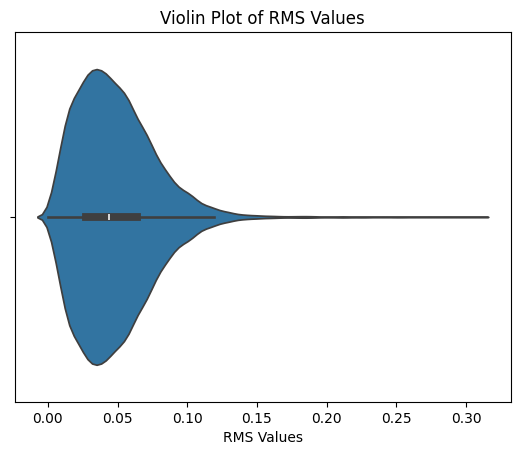

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot
sns.violinplot(x=df['RMS'])

# Adding titles and labels (optional, but recommended for clarity)
plt.title('Violin Plot of RMS Values')
plt.xlabel('RMS Values')

# Display the plot
plt.show()

Next steps:
Determine the Target RMS Value: Decide on a target RMS value to normalize all clips to. This could be based on your application's specific needs or preferences. A common approach is to use the average RMS value across all clips, but you might choose a different target, such as the 75th percentile, to preserve more of the dynamic range in the clips.

Calculate the Adjustment Factor: For each audio clip, calculate the adjustment factor needed to bring its RMS value to the target level. The adjustment factor is the ratio of the target RMS to the clip's current RMS.

Apply the Adjustment Factor: Adjust each clip's volume by multiplying its audio signal by the calculated adjustment factor. This operation should normalize the RMS value of the clip to the target level.

Consider Clipping: Ensure that the normalization process does not cause any audio clip to clip (i.e., exceed the maximum amplitude allowed in the audio format). If the adjusted signal exceeds this limit, you might need to apply dynamic range compression or limit the gain applied to prevent clipping.

In [ ]:
import numpy as np

# Assuming `audio_signals` is a list where each element is a numpy array representing an audio clip
# and `target_rms` is the RMS level you want to normalize all clips to

def calculate_rms(audio_signal):
    return np.sqrt(np.mean(np.square(audio_signal)))

def normalize_audio_clips(audio_signals, target_rms):
    normalized_signals = []
    for signal in audio_signals:
        current_rms = calculate_rms(signal)
        adjustment_factor = target_rms / current_rms
        # Apply adjustment factor, with a check to prevent clipping
        normalized_signal = np.minimum(signal * adjustment_factor, 1.0)
        normalized_signals.append(normalized_signal)
    return normalized_signals

# Example target RMS
target_rms = 0.05  # This value should be chosen based on your specific needs

# Normalize all clips (this is a conceptual example; implementation details may vary)
normalized_audio_clips = normalize_audio_clips(audio_signals, target_rms)


# Modelling

In [ ]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from joblib import dump

def load_and_preprocess_data(df_path, features_csv_path, scaler_path):
    """Loads or generates data, extracts features if necessary, applies scaling, and optionally saves features to a CSV."""
    if features_csv_path.is_file():
        # Load features and labels from the CSV
        features_df = pd.read_csv(features_csv_path)
        labels = features_df['Label'].values
        features = features_df.drop(columns=['Label']).values
    else:
        # Load and process data from scratch
        df = pd.read_csv(df_path)
        features = np.array([extract_features(path) for path in df['ClipPath']])
        labels = df['Fluency Label'].values
        
        # Save features and labels to a CSV if a path is provided
        if features_csv_path:
            features_df = pd.DataFrame(features)
            features_df['Label'] = labels
            features_df.to_csv(features_csv_path, index=False)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save the scaler for future use
    dump(scaler, scaler_path)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Main script
df_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\SEP-28k_labels.csv'
features_csv_path_input = ''  # Optional: Path to an existing features CSV. Leave as '' to generate from scratch.
features_csv_path = Path(features_csv_path_input) if features_csv_path_input else Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\features_labels.csv')
scaler_path = Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-2-SCALER.joblib')
model_path = Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-2.joblib')

# Check if a custom path for the features CSV is provided, if not, use the default path
if not features_csv_path_input:
    print("No custom features CSV path provided. Generating features and saving to default path.")
else:
    print(f"Using provided features CSV path: {features_csv_path}")

# Load, preprocess data, and save features to a CSV if necessary
X_train, X_test, y_train, y_test = load_and_preprocess_data(df_path, features_csv_path, scaler_path)

# Train the model and evaluate its performance
train_and_evaluate(X_train, X_test, y_train, y_test, model_path)


In [7]:
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from joblib import dump

def extract_features(audio_path):
    """Extracts MFCC features from an audio file."""
    y, sr = librosa.load(audio_path)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    return mfccs

def load_and_preprocess_data(df, features_csv_path, scaler_path):
    """Loads or generates data, extracts features if necessary, applies scaling, and optionally saves features to a CSV."""
    if features_csv_path.is_file():
        # Load features and labels from the CSV
        features_df = pd.read_csv(features_csv_path)
        labels = features_df['Label'].values
        features = features_df.drop(columns=['Label']).values
    else:
        # Load and process data from scratch
        features = np.array([extract_features(path) for path in df['ClipPath']])
        labels = df['Fluency Label'].values
        
        # Save features and labels to a CSV if a path is provided
        if features_csv_path:
            features_df = pd.DataFrame(features)
            features_df['Label'] = labels
            features_df.to_csv(features_csv_path, index=False)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save the scaler for future use
    dump(scaler, scaler_path)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_and_evaluate(X_train, X_test, y_train, y_test, model_path):
    """Trains a RandomForestClassifier and evaluates its accuracy."""
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model Accuracy: {accuracy:.2f}')
    
    # Save the trained model
    dump(model, model_path)

features_csv_path_input = ''  # Optional: Path to an existing features CSV. Leave as '' to generate from scratch.
features_csv_path = Path(features_csv_path_input) if features_csv_path_input else Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\features_labels.csv')
scaler_path = Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-2-SCALER.joblib')
model_path = Path(r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-2.joblib')

# Check if a custom path for the features CSV is provided, if not, use the default path
if not features_csv_path_input:
    print("No custom features CSV path provided. Generating features and saving to default path.")
else:
    print(f"Using provided features CSV path: {features_csv_path}")

# Load, preprocess data, and save features to a CSV if necessary
X_train, X_test, y_train, y_test = load_and_preprocess_data(simple_df, features_csv_path, scaler_path)

# Train the model and evaluate its performance
train_and_evaluate(X_train, X_test, y_train, y_test, model_path)


No custom features CSV path provided. Generating features and saving to default path.
Model Accuracy: 0.65


In [ ]:
#import model and calc y_pred again and maybe add in feature saving

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


NameError: name 'y_pred' is not defined

# Usage

In [26]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import load
# import sounddevice as sd

# Feature extraction function
def extract_features_usage(audio_signal, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13), axis=1)
    # You can add more features here
    return mfccs


# Function to split the audio signal into chunks of 3 seconds
def split_audio_signal(y, sr, chunk_length=3):
    chunk_size = chunk_length * sr  # Chunk size in samples
    chunks = [y[i:i + chunk_size] for i in range(0, len(y), chunk_size) if i + chunk_size <= len(y)]
    return chunks

# Function to make predictions on chunks and calculate final score
def predict_and_score(audio_path, model):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    # Split the audio signal into 3-second chunks
    chunks = split_audio_signal(y, sr)


    # Load the saved scaler
    scaler_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-SCALER.joblib' 
    scaler = load(scaler_path)

    predictions = []
    for chunk in chunks:
        features = extract_features_usage(chunk, sr)
        features = scaler.transform(features.reshape(1, -1))  # Scaling the features
        predictions.append(model.predict(features)[0])
    
    # Calculate the final fluency score (you might want to use a different formula here)
    fluency_score = np.mean(predictions)

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    predictions_df.to_csv('predictions.csv', index=False)
    
    return fluency_score

# Example: Predict the fluency score of an audio file
audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\test_audio\do-schools-kill-creativity-sir-ken-robinson-ted.wav'
# audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\test_audio\Creating-a-Safe-Space-at-Work-For People-Who-Stutter.wav'
# audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\[WAV_DIR]\FluencyBank\010.wav'

final_score = predict_and_score(audio_file_path, model)
print(f"The final fluency score is: {final_score}")



The final fluency score is: 0.18


In [28]:
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from joblib import load
import soundfile as sf
import os

# Feature extraction function remains the same

# Modified function to split the audio signal into chunks of 3 seconds and return chunk indices
def split_audio_signal(y, sr, chunk_length=3):
    chunk_size = chunk_length * sr  # Chunk size in samples
    chunks = [(y[i:i + chunk_size], i // chunk_size) for i in range(0, len(y), chunk_size) if i + chunk_size <= len(y)]
    return chunks

# Updated function to make predictions on chunks, calculate final score, save chunks, and save predictions with chunk names
def predict_and_score(audio_path, model):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    # Split the audio signal into 3-second chunks
    chunks = split_audio_signal(y, sr)

    # Load the saved scaler
    scaler_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-models\binary-randforrest-SCALER.joblib' 
    scaler = load(scaler_path)

    chunks_directory = r'C:\Users\ojmar\Documents\Uni\StammerScore\temp-model-storage'

    predictions = []
    chunk_names = []
    for chunk, index in chunks:
        # Save each chunk as an audio file
        chunk_name = f"chunk_{index}.wav"
        chunk_path = os.path.join(chunks_directory, chunk_name)
        sf.write(chunk_path, chunk, sr)
        chunk_names.append(chunk_name)

        features = extract_features_usage(chunk, sr)
        features = scaler.transform(features.reshape(1, -1))  # Scaling the features
        predictions.append(model.predict(features)[0])

    # Create a DataFrame with chunk names and predictions
    predictions_df = pd.DataFrame({
        'ChunkName': chunk_names,
        'Prediction': predictions
    })
    predictions_df.to_csv('chunk_predictions.csv', index=False)

    # Calculate the final fluency score (optional)
    fluency_score = np.mean(predictions)

    return fluency_score



# Example: Predict the fluency score of an audio file
# audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\test_audio\do-schools-kill-creativity-sir-ken-robinson-ted.wav'
# audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\test_audio\Creating-a-Safe-Space-at-Work-For People-Who-Stutter.wav'
audio_file_path = r'C:\Users\ojmar\Documents\Uni\StammerScore\ml-stuttering-events-dataset\[WAV_DIR]\FluencyBank\010.wav'

final_score = predict_and_score(audio_file_path, model)
print(f"The final fluency score is: {final_score}")


The final fluency score is: 0.20903954802259886
